In [ ]:
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Parameter
from torchvision import datasets, transforms

In this seminar we will implement **Variational Dropout**

Author: [Evgenii Egorov](mailto:egorov.evgenyy@ya.ru)


#### Reference:
[1] [Variational Dropout and the Local Reparameterization Trick](https://arxiv.org/pdf/1506.02557.pdf), Kingma et. al., 2015\
[2] [Variational Dropout Sparsifies Deep Neural Networks](https://arxiv.org/pdf/1701.05369.pdf), Molchanov et. al., 2017\
[3] Deep Bayes School http://deepbayes.ru


## Task 1. 
Implement Linear Stohastic Layer
$$
f(x) = Wx + b, \\
w_{ij} \sim \mathcal{N}(w_{ij}|\mu_{ij}, \alpha_{ij} \mu_{ij}^2).
$$

$$
\text{KL}(q(w)\|p(w)) \approx \sum_{i, j} \log (1 + \alpha_{ij}^{-1}).
$$

In [ ]:
class LinearStoch(nn.Module):
    def __init__(self, in_f, out_f, bias=True):
        super(LinearStoch, self).__init__()
        self.in_f = in_f
        self.out_f = out_f
        
        self.W = Parameter(torch.Tensor(out_f, in_f)) # Mean
        self.log_std = Parameter(torch.Tensor(out_f, in_f)) # Log sigma
        self.bias = Parameter(torch.Tensor(1, out_f))
        
        self.init_w()
        
    def init_w(self):
        self.bias.data.zero_()
        self.W.data.normal_(0, 0.01)
        self.log_std.data.fill_(-3)        
        
    def log_alpha(self):
        """
        Calculate log_alpha and mask for the weight matrix
        """
        # YOUR CODE HERE
        log_alpha = -2*(torch.log(torch.abs(self.W)) - self.log_std)
        mask = (log_alpha < 3).float()
        return log_alpha, mask
        # END CODE
    
    def forward(self, x, training=True):
        # YOUR CODE HERE
        if training:
            a_m = F.linear(x, self.W) + self.bias
            a_std = torch.sqrt(F.linear(x * x, torch.exp(self.log_std * 2.)) + 1e-9)
            return a_m + a_std * torch.randn_like(a_std)
        log_alpha, mask = self.log_alpha()
        return F.linear(x, self.W * mask) + self.bias
        # END CODE
    
    def kl_reg(self):
        # YOUR CODE HERE
        log_alpha, mask = self.log_alpha()
        return torch.sum(torch.log(1.+torch.exp(-log_alpha)))
        # END CODE

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = LinearStoch(28*28, 300)
        self.fc2 = LinearStoch(300,  100)
        self.fc3 = LinearStoch(100,  10)
       
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [ ]:
def get_mnist(batch_size):
    trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True, num_workers=4)
    return train_loader, test_loader

## Task 2. 
Implement Loss function



In [ ]:
class SGVLB(nn.Module):
    def __init__(self, net, train_size):
        super(SGVLB, self).__init__()
        self.train_size = train_size
        self.net = net

    def forward(self, input, target, kl_weight=1.0):
        # YOUR CODE HERE
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        return F.nll_loss(input, target) * self.train_size + kl_weight * kl
        # END CODE

In [ ]:
model = Net().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,70,80], gamma=0.2)

train_loader, test_loader = get_mnist(batch_size=100)
sgvlb = SGVLB(model, len(train_loader.dataset)).cuda()

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def make_validation():
    model.eval()
    test_loss, test_acc = 0., 0.
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.cuda()
        target = target.cuda()
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(sgvlb(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())
    return np.round(test_loss / len(test_loader.dataset),3), np.round(test_acc / len(test_loader.dataset), 2)

## Task 3.
Train the model

In [ ]:
kl_weight = 0.02
epochs = 100

for epoch in range(1, epochs + 1):
    model.train()
    train_loss, train_acc = 0, 0 
    kl_weight = min(kl_weight+0.02, 1)
    for batch_idx, (data, target) in enumerate(train_loader):
      # YOUR CODE HERE
        data = data.cuda()
        target = target.cuda()
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        
        output = model(data)
        pred = output.data.max(1)[1] 
        loss = sgvlb(output, target, kl_weight)
        loss.backward()
        optimizer.step()
      # END CODE
      
        train_loss += loss 
        train_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())
    scheduler.step()
    
    tr_loss = np.round(train_loss.item() / len(train_loader.dataset),3)
    tr_acc = np.round(train_acc.item() / len(train_loader.dataset), 2)
    tt_loss, tt_acc =  make_validation()
    print(f"acc: test {tt_acc} train {tr_acc} \t \t loss train {tr_loss} test {tt_loss}")

acc: test 0.95 train 0.84 	 	 loss train 310.872 test 130.414
acc: test 0.96 train 0.96 	 	 loss train 123.749 test 109.813
acc: test 0.96 train 0.97 	 	 loss train 110.445 test 113.291
acc: test 0.97 train 0.97 	 	 loss train 107.412 test 111.908
acc: test 0.97 train 0.97 	 	 loss train 106.184 test 107.565
acc: test 0.97 train 0.97 	 	 loss train 104.289 test 111.488
acc: test 0.97 train 0.97 	 	 loss train 105.306 test 113.725
acc: test 0.97 train 0.98 	 	 loss train 103.403 test 120.521
acc: test 0.97 train 0.98 	 	 loss train 106.37 test 114.672
acc: test 0.97 train 0.98 	 	 loss train 105.388 test 112.878
acc: test 0.97 train 0.98 	 	 loss train 104.893 test 113.518
acc: test 0.97 train 0.98 	 	 loss train 103.607 test 111.252
acc: test 0.97 train 0.98 	 	 loss train 105.028 test 121.544
acc: test 0.97 train 0.98 	 	 loss train 104.929 test 119.431
acc: test 0.97 train 0.98 	 	 loss train 104.567 test 123.194
acc: test 0.97 train 0.98 	 	 loss train 106.103 test 124.403
acc: test

## Task 4.

Calculate the proportion of parameters, which were not zeroed out. 

In [ ]:
# YOUR CODE HERE
all_w, kep_w = 0., 0.
for c in model.children():
    log_alpha, mask = c.log_alpha()
    mask = mask.data.cpu().numpy()
    kep_w += mask.sum()
    all_w += mask.size
print('keept weight ratio =', kep_w/all_w)
# END CODE

keept weight ratio = 0.07416228399699475


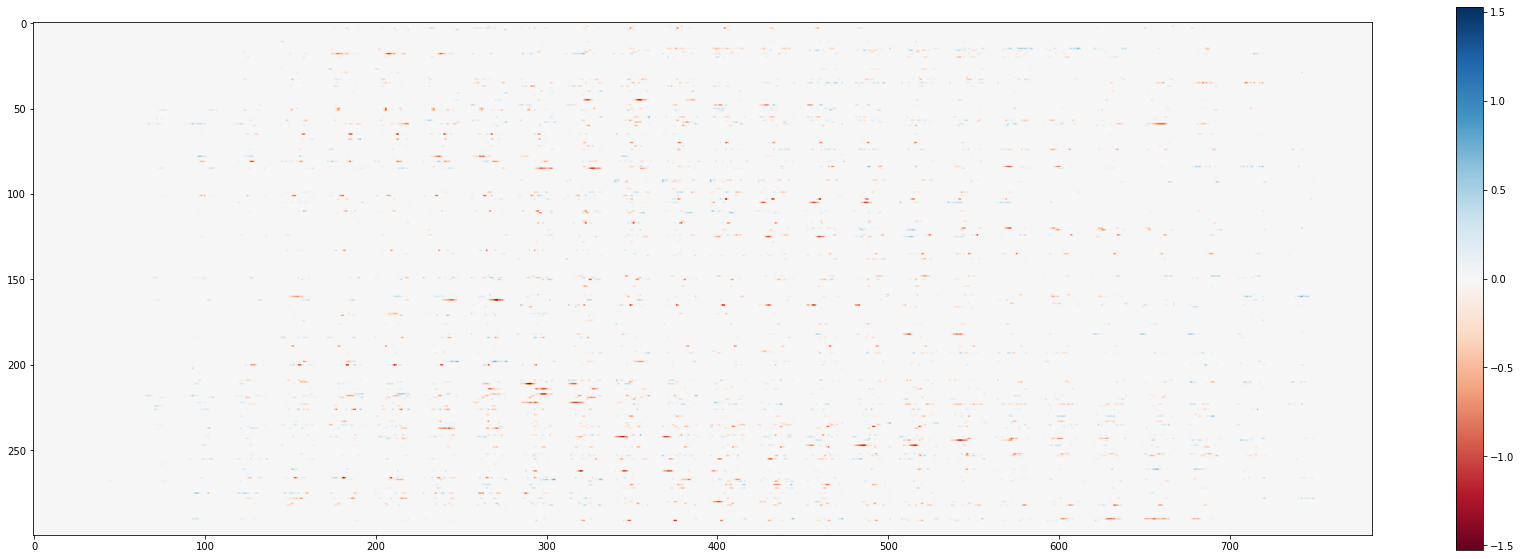

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,10))

log_alpha, mask  = model.fc1.log_alpha()
mask = mask.cpu().detach().numpy();
W = model.fc1.W.cpu().detach().numpy();

max_val = np.max(np.abs(mask * W))
norm = mpl.colors.Normalize(vmin=-max_val,vmax=max_val)

plt.imshow(mask * W, cmap='RdBu', interpolation=None, norm=norm);
plt.colorbar();